In [2]:
import sys
sys.path.insert(0, '/opt/homebrew/Cellar/pythia/8.309/lib')
import pythia8

In [3]:
import gen
import analyzer

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skopt import Optimizer

In [5]:
instructions = {
    'Print:quiet': 'on',

    'Beams:frameType': '2',

    'Beams:idA': '2212',
    'Beams:idB': '2212',

    'Beams:eA': '158',
    'Beams:eB': '0',

    'SoftQCD:all': 'on',

    'Tune:pp': '1',

    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on',
    }

In [6]:
pythia = pythia8.Pythia("", False)
for inst, val in instructions.items():    
    pythia.readString(f'{inst} = {val}')
pythia.init()
sigma = pythia.getSigmaTotal()

In [7]:
ref = pd.read_csv('../exp_data/na49/211.csv')
ref.head()

,xF,pT,xsect,error
0,0.0,0.05,62.87363,0.38353
1,0.0,0.10,59.66060,0.34603
2,0.0,0.15,51.19669,0.28158
3,0.0,0.20,41.41528,0.26920
4,0.0,0.25,31.99847,0.18239


In [8]:
bins_file = open('/Volumes/Transcend/Documents/Study/particles/exp_data/na49/binning.bin', 'r')
bins = []
for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))
bins = np.array(bins)
bins_file.close()

In [38]:
xsect_ref = []
error_ref = []

for bin in bins:

    xF = bin[0]
    pT = bin[1]

    dxF = bin[2]
    dpT = bin[3]

    mask_for_bin = (ref['xF'] == xF) * (ref['pT'] == pT)

    if mask_for_bin.sum() > 0:
        xsect_ref.append(ref[mask_for_bin]['xsect'].values[0])
        error_ref.append(ref[mask_for_bin]['error'].values[0])
    else: 
        xsect_ref.append(0.)
        error_ref.append(0.)

xsect_ref = np.array(xsect_ref)
error_ref = np.array(error_ref)

In [34]:
N = int(5e6)

In [76]:
gen_res = gen.generate(instructions=instructions, num_events=N, n_jobs=8)
xsect_base, error_base = analyzer.analyze(gen_res=gen_res, sigma=sigma, n_events=N)

res_base = np.mean(
    (xsect_base - xsect_ref) ** 2 / \
    (np.where(
        (error_base ** 2 + error_ref ** 2) == 0,
        1, error_base ** 2 + error_ref ** 2
        )),
)

print(res_base)

112.24745487705366


In [10]:
optim_params = {
    #'ColourReconnection:range': [0.0, 10.0],
    #'MultipartonInteractions:alphaSvalue': [0.06, 0.25],
    #'MultipartonInteractions:ecmPow': [0.0, 0.50000],
    #'MultipartonInteractions:expPow': [0.40000, 10.00000],
    #'MultipartonInteractions:pT0Ref': [0.50000, 10.00000],
    'SigmaProcess:alphaSvalue': [0.0600000, 0.25000],
    'SpaceShower:alphaSvalue': [0.0600000, 0.25000],
    'SpaceShower:ecmPow': [0.0, 0.50000],
    'SpaceShower:pT0Ref': [0.50000, 10.00000],
    'StringFlav:etaSup': [0.0, 1.00000],
    'StringFlav:mesonBvector': [0.0, 3.00000],
    'StringFlav:mesonCvector': [0.0, 3.00000],
    'StringFlav:mesonSvector': [0.0, 3.00000],
    'StringFlav:mesonUDvector': [0.0, 3.00000],
    'StringFlav:popcornSpair': [0.0, 1.00000],
    'StringFlav:probQQ1toQQ0': [0.0, 1.00000],
    'StringFlav:probQQtoQ': [0.0, 1.00000],
    'StringFlav:probSQtoQQ': [0.0, 1.00000],
    'StringFlav:probStoUD': [0.0, 1.00000],
    'StringPT:sigma': [0.0, 1.0],
    'StringZ:aExtraDiquark': [0.0, 2.0],
    'StringZ:aLund': [0.0, 2.00000],
    'StringZ:bLund':[0.20000, 2.00000],
    'StringZ:rFactB': [0.0, 2.00000],
    'StringZ:rFactC': [0.0, 2.00000],
    'TimeShower:alphaSvalue': [0.0600000, 0.25000],
    'TimeShower:pTmin': [0.10000, 2.00000],
    'TimeShower:pTminChgQ': [0.10000, 2.00000]
}

In [30]:
def objective(x, N):

    params = {}

    for num, param in enumerate(optim_params.keys()):
        params[param] = x[num]

    new_instructions = {}
    new_instructions.update(instructions)
    new_instructions.update(params)

    gen_res = gen.generate(instructions=new_instructions, num_events=N, n_jobs=8)
    xsect, error = analyzer.analyze(gen_res, sigma, N)

    res = np.mean(
        (xsect - xsect_ref) ** 2 / \
        (np.where(
            (error ** 2 + error_ref ** 2) == 0,
            1, error ** 2 + error_ref ** 2
            ))
    )
    
    return res

In [12]:
def save_answ(Xi, yi):

    answ = {'f': yi}

    Xi_t = np.transpose(Xi)

    for num, key in enumerate(optim_params.keys()):

        answ[key] = Xi_t[num]

    answ = pd.DataFrame(answ)
    answ.to_csv(f'answer.csv', index=False)

In [153]:
n_initial_points = 100

opt_gp = Optimizer(list(optim_params.values()),
                   base_estimator="GP",
                   n_initial_points=n_initial_points,
                   acq_optimizer="sampling", acq_func='EI',
                   random_state=42)

In [156]:
itrs = 1000
verbose = 50

for i in range(itrs):
    
    next_x = opt_gp.ask()
    f_val = objective(next_x, N)
    res = opt_gp.tell(next_x, f_val)

    if i % verbose == 0 or i == itrs - 1:
        print(f'Iteration {i} finished, f={f_val:.5}')
        save_answ(opt_gp.Xi, opt_gp.yi)

Iteration 999 finished, f=3.4561


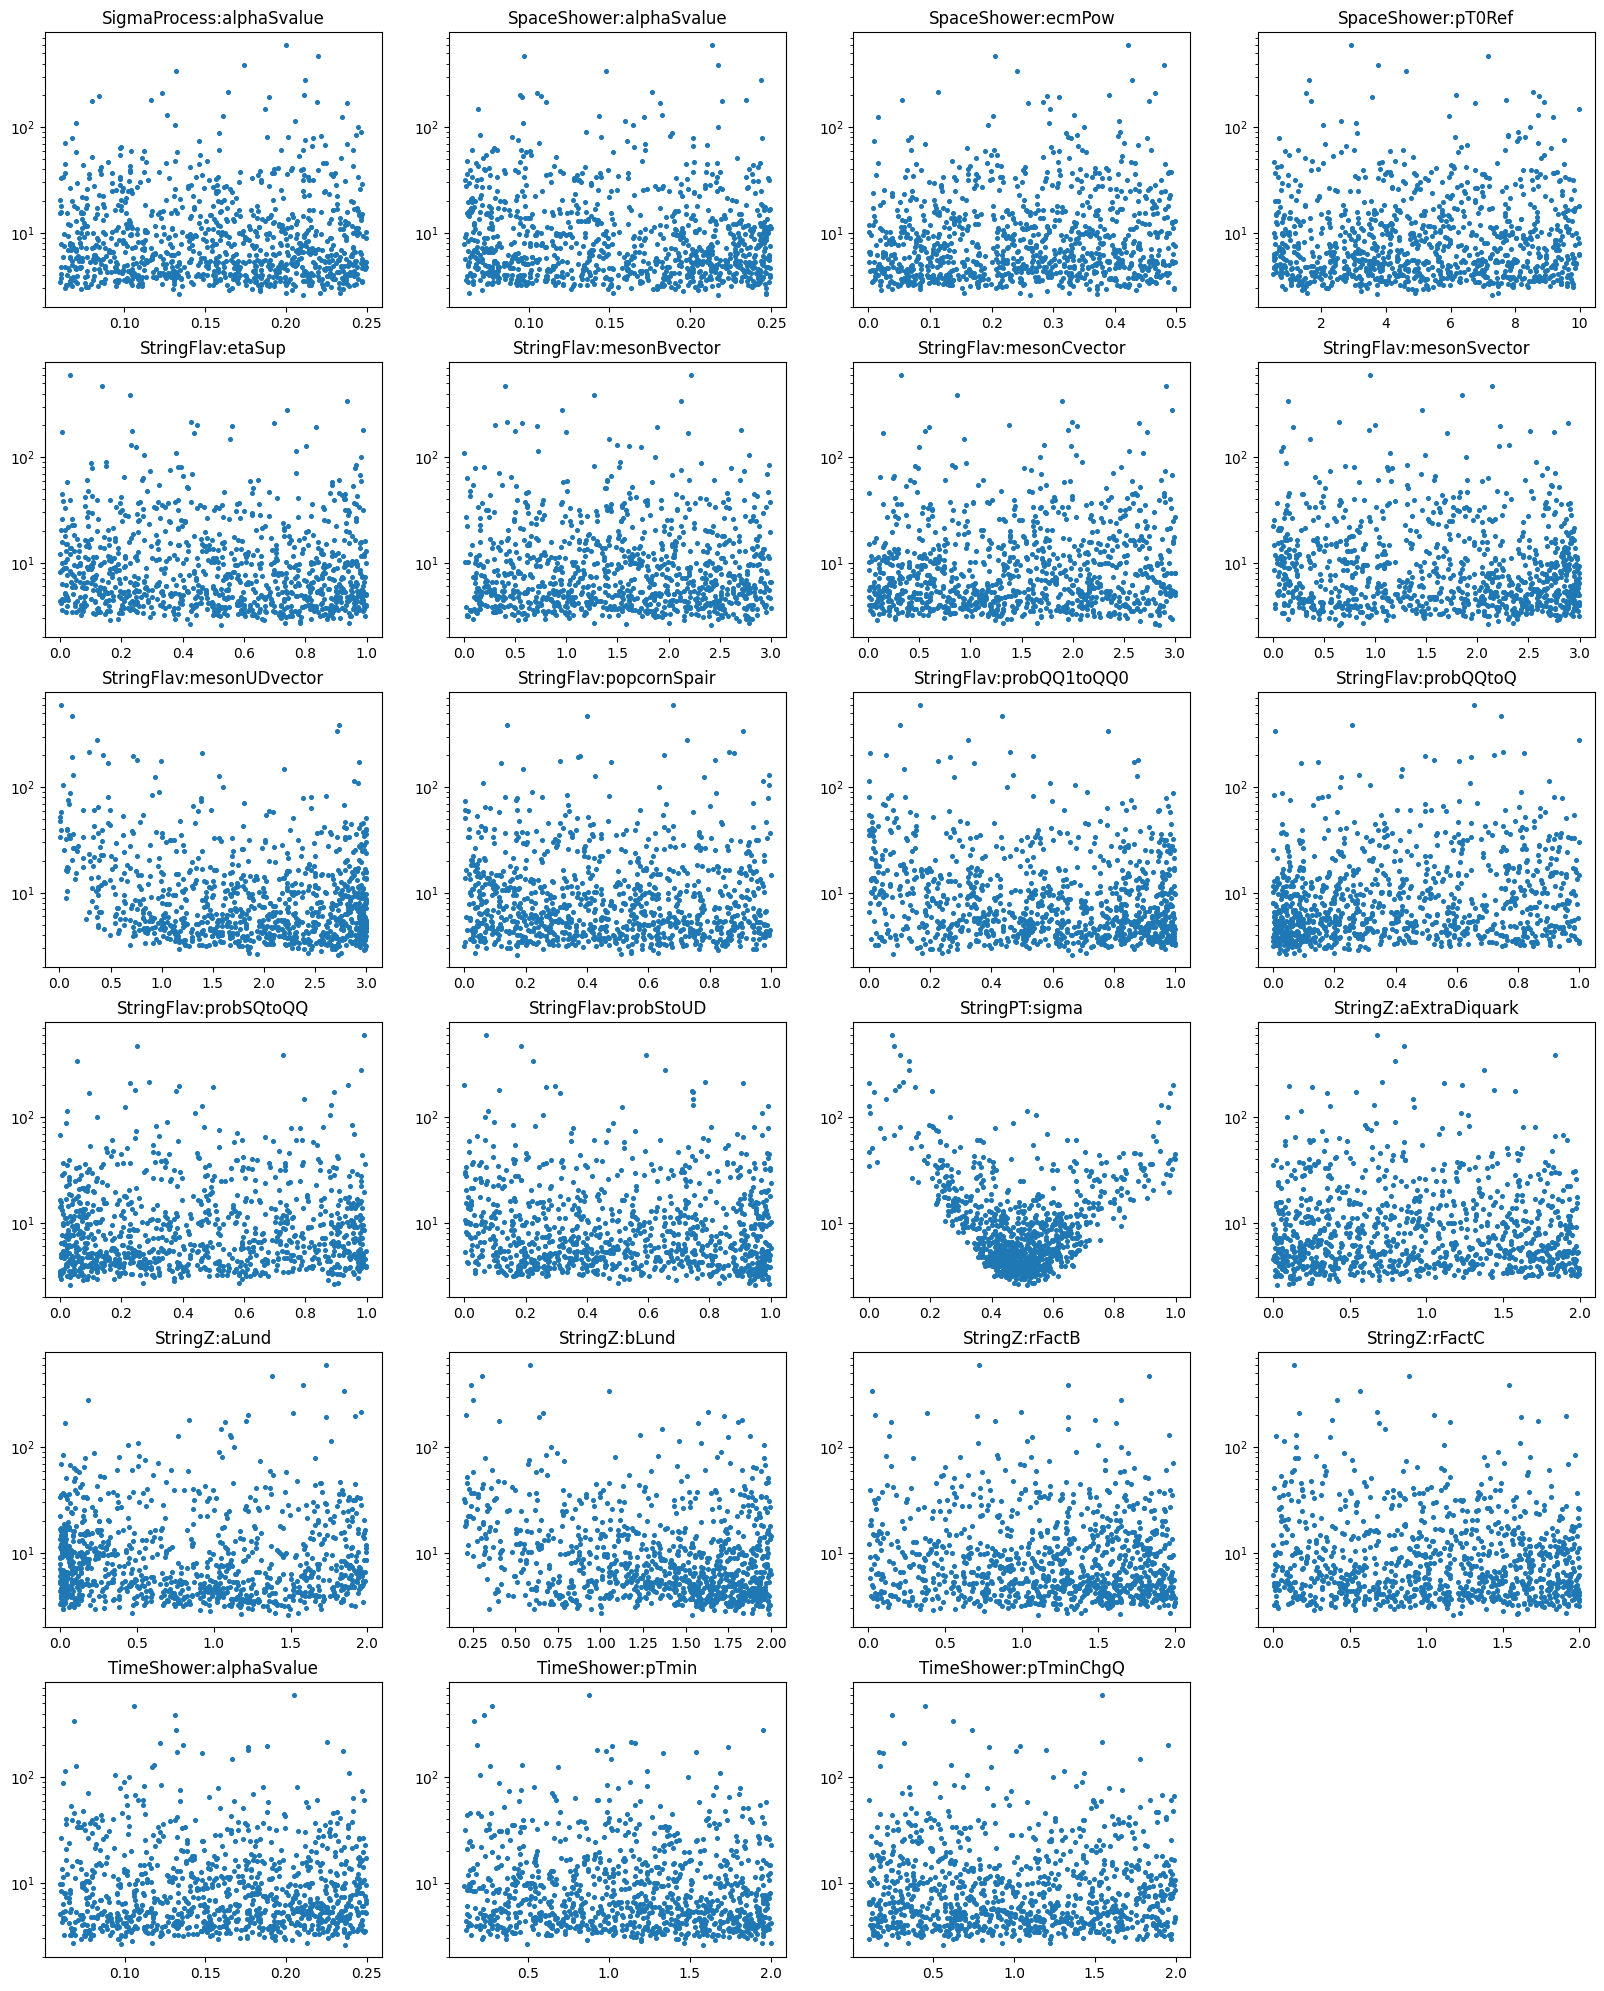

In [14]:
df = pd.read_csv('answer.csv')

f = df['f']
params = df.drop('f', axis=1)

plt.figure(figsize=(20, 25))

for i in range(params.shape[1]):

    plt.subplot(params.shape[1] // 4 + 1, 4, i + 1)
    plt.scatter(params.values[:,i], f, s=7)
    plt.title(params.columns[i])
    plt.yscale('log')

plt.show()

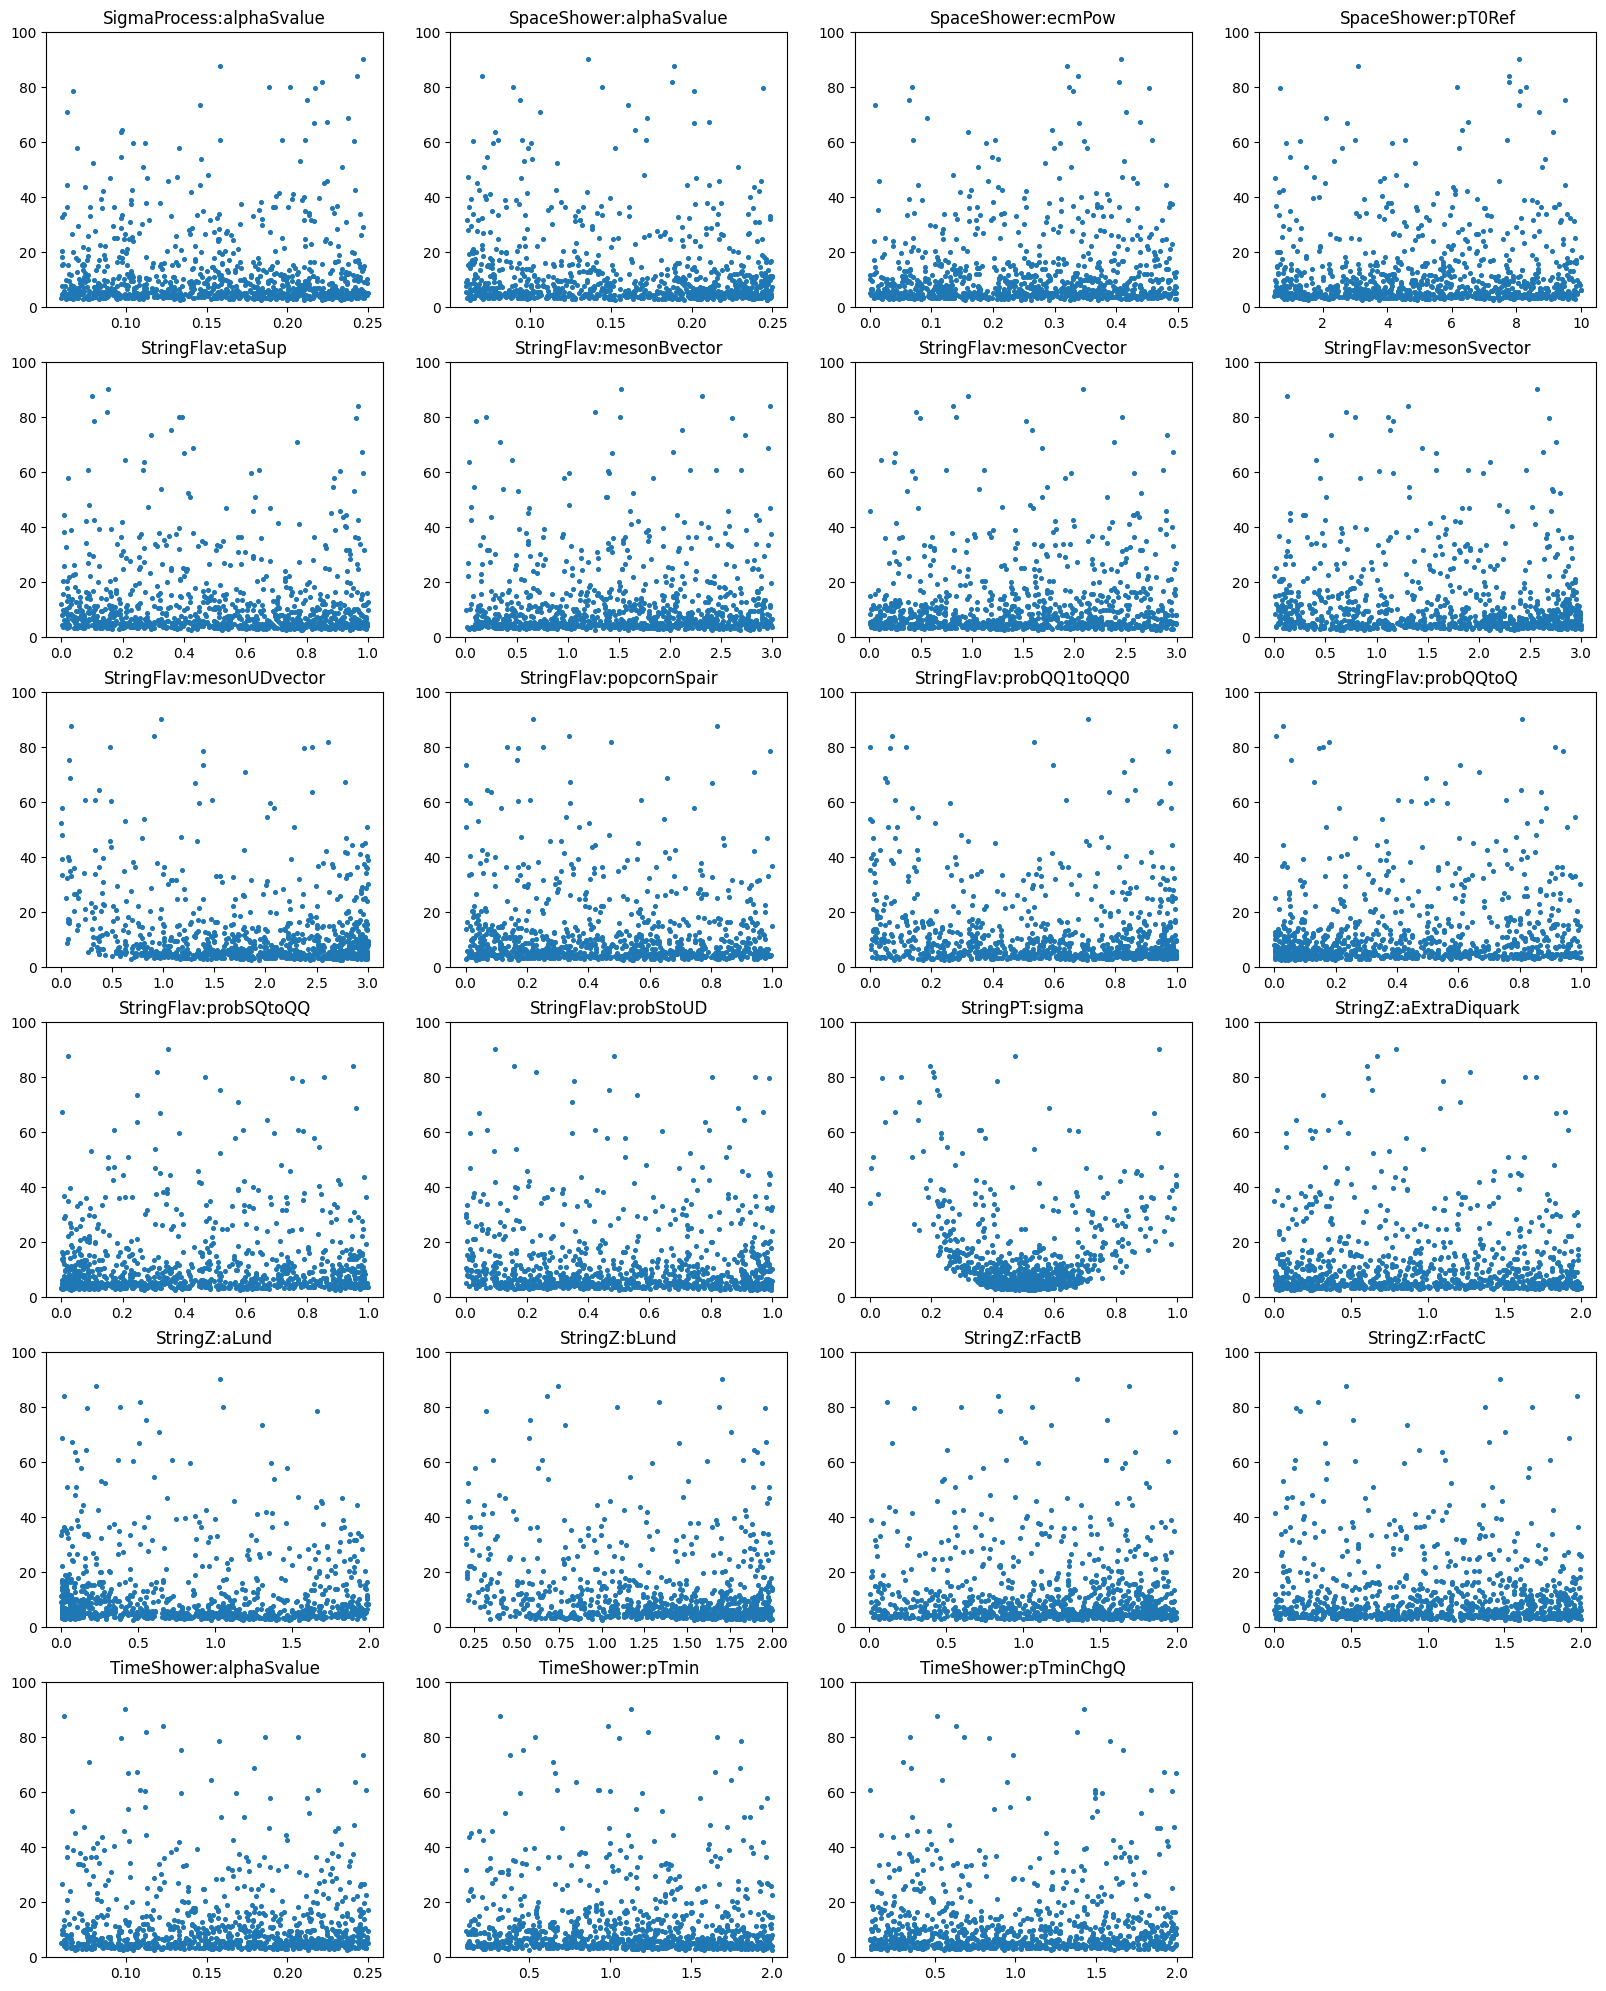

In [15]:
df = pd.read_csv('answer.csv')

f = df['f']
params = df.drop('f', axis=1)

plt.figure(figsize=(20, 25))

for i in range(params.shape[1]):

    plt.subplot(params.shape[1] // 4 + 1, 4, i + 1)
    plt.scatter(params.values[:,i], f, s=7)
    plt.title(params.columns[i])
    plt.ylim((0, 100))

plt.show()

In [78]:
best_params = {}

for num, param in enumerate(optim_params.keys()):
    best_params[param] = params.iloc[f.argmin()].values[num]

new_instructions = {}
new_instructions.update(instructions)
new_instructions.update(best_params)

gen_res = gen.generate(instructions=new_instructions, num_events=N, n_jobs=8)
xsect_opt, error_opt = analyzer.analyze(gen_res=gen_res, sigma=sigma, n_events=N)

res_opt = np.mean(
    (xsect_opt - xsect_ref) ** 2 / \
    (np.where(
        (error_opt ** 2 + error_ref ** 2) == 0,
        1, error_opt ** 2 + error_ref ** 2
        )),
)

print(res_opt)

51.48916217672607


In [112]:
best_params

{'SigmaProcess:alphaSvalue': 0.2104509056649068,
 'SpaceShower:alphaSvalue': 0.2174255129491408,
 'SpaceShower:ecmPow': 0.2626293419783355,
 'SpaceShower:pT0Ref': 7.283734024724842,
 'StringFlav:etaSup': 0.5236933755307055,
 'StringFlav:mesonBvector': 2.4119604509333805,
 'StringFlav:mesonCvector': 2.840285047386028,
 'StringFlav:mesonSvector': 0.6447182162167617,
 'StringFlav:mesonUDvector': 2.726912423456251,
 'StringFlav:popcornSpair': 0.170682448284757,
 'StringFlav:probQQ1toQQ0': 0.6634772371774383,
 'StringFlav:probQQtoQ': 0.100754776725974,
 'StringFlav:probSQtoQQ': 0.0321311609330337,
 'StringFlav:probStoUD': 0.9498701027661,
 'StringPT:sigma': 0.5157193552737201,
 'StringZ:aExtraDiquark': 0.0309399181524356,
 'StringZ:aLund': 1.4841424623761088,
 'StringZ:bLund': 1.5390289835970627,
 'StringZ:rFactB': 1.104965771639406,
 'StringZ:rFactC': 1.172738764418552,
 'TimeShower:alphaSvalue': 0.236916710087333,
 'TimeShower:pTmin': 1.581653304126256,
 'TimeShower:pTminChgQ': 0.56033194

In [135]:
def plot_compare(xsect, error, label):

    xFs = ref['xF'].unique()

    for num, xF in enumerate(xFs):

        pTs = ref['pT'][ref['xF'] == xF].values
        
        bins_mask = (bins[:, 0] == xF)
        pTs_ploted, bins_ploted = np.intersect1d(
            pTs, bins[bins_mask][:, 1], 
            return_indices=True
        )[1:]

        plt.subplot(len(xFs), 3, 3 * num + 1)    
        plt.title(f'$xF={xF}$')
        plt.errorbar(
            pTs[pTs_ploted], xsect[bins_mask][bins_ploted],
            yerr=error[bins_mask][bins_ploted],
            label=label
        )
        plt.xlabel('pT')
        plt.ylabel('xsect')
        plt.legend()

        plt.subplot(len(xFs), 3, 3 * num + 2)  
        plt.title(f'$xF={xF}$ log scale')  
        plt.errorbar(
            pTs[pTs_ploted], xsect[bins_mask][bins_ploted],
            yerr=error[bins_mask][bins_ploted],
            label=label
        )
        plt.xlabel('pT')
        plt.ylabel('log(xsect)')
        plt.yscale('log')
        plt.legend()

        plt.subplot(len(xFs), 3, 3 * num + 3)
        deviation = (xsect / (xsect_ref + 1e-8) - 1)[bins_mask][bins_ploted]
        deviation_error = np.abs(
            deviation * \
            ((error[bins_mask][bins_ploted] / xsect[bins_mask][bins_ploted]) ** 2 + \
            (error_ref[bins_mask][bins_ploted] / xsect_ref[bins_mask][bins_ploted]) ** 2) ** 0.5
        )
        plt.title(f'$xF={xF}$ deviation')  
        plt.errorbar(
            pTs[pTs_ploted], deviation,
            yerr=deviation_error,
            label=label
        )
        plt.xlabel('pT')
        plt.ylabel('deviation')
        plt.legend()

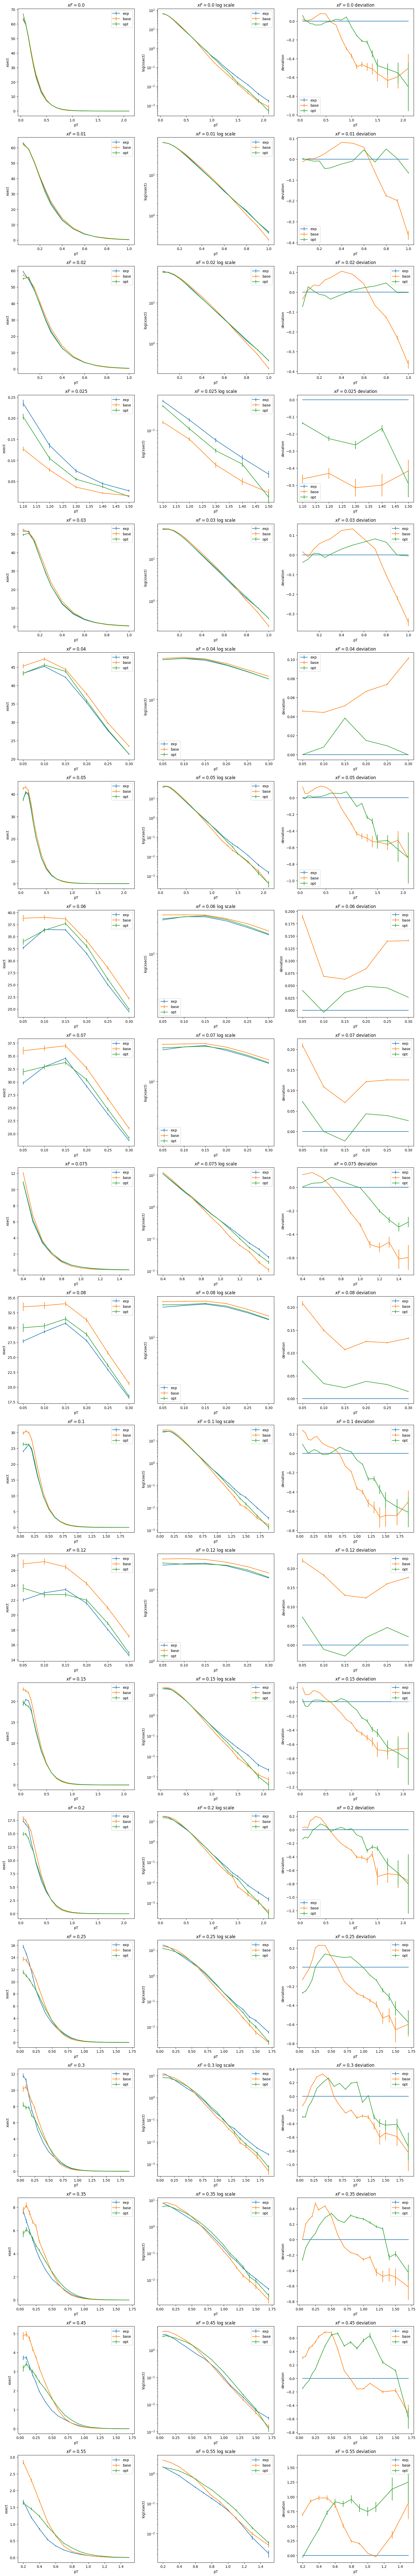

In [136]:
plt.figure(figsize=(20, 130))

plot_compare(xsect_ref, error_ref, 'exp')
plot_compare(xsect_base, error_base, 'base')
plot_compare(xsect_opt, error_opt, 'opt')

plt.show()